# Autotuning and pitch shift/time stretching 

### George Tzanetakis, University of Victoria 

In this notebook we will create a simple auto-tuner. It consists of mono-phonic 
pitch detection followed by pitch shifting as needed to conform to a particular scale/collection 
of pitches. There are three steps in the process: 

1. Monophonic pitch extraction
2. Mapping of each pitch to a target pitch 
3. Pitch shifting audio without time stretching 

We have already covered pitch extraction. Our auto-tuner will be very simple and just to illustrate 
the basic principles behind. Steps 2 and 3 will be briefly described.

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.interpolate import interp1d 
import IPython.display as ipd

Let's load an audio recording

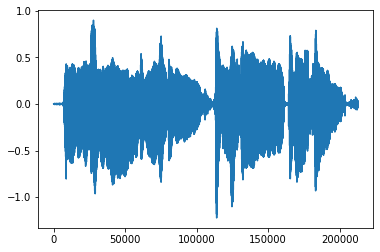

In [2]:
import scipy.io.wavfile as wav
srate, audio_signal = wav.read("amazing_grace_female.wav")
# scale to -1.0/1.0 
audio_signal = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
audio_signal = (0.9 / max(audio_signal)) * audio_signal

plt.figure() 
plt.plot(audio_signal)
ipd.Audio(audio_signal,rate=srate)


Now that we have seen how we can estimate the pitch of a single frame of audio 
we can abstract this process into functions and then write a function that 
given an audio signal returns the associated pitch track and amplitude track (RMS) 
using a particular pitch extraction method. 

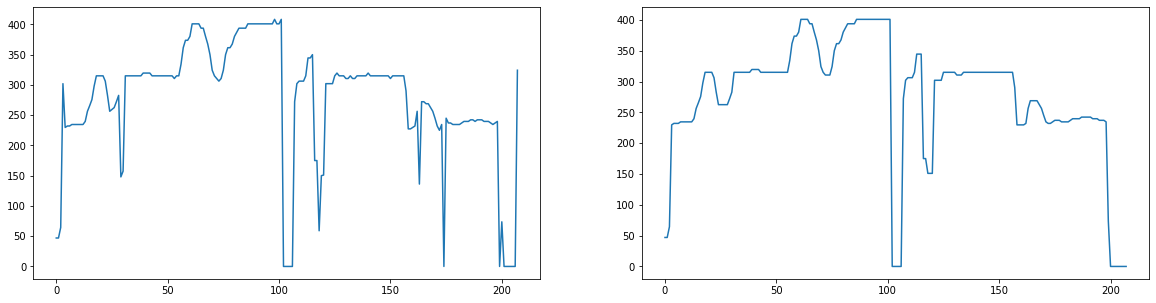

In [3]:

def pitch_zcrs(frame, srate): 
    indices = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]
    pitch_estimate = (srate / np.mean(np.diff(indices)))
    return pitch_estimate 

def pitch_fft(frame, srate): 
    mag = np.abs(np.fft.fft(frame))
    mag = mag[0:int(len(mag)/2)]
    pitch_estimate = np.argmax(mag) * (srate / len(frame))
    return pitch_estimate 
    
def pitch_acr(frame, srate): 
    acr = np.correlate(frame, frame, mode='full')
    acr = acr[int(len(acr)/2):]
    low_lag = np.argmin(acr)
    max_lag = np.argmax(acr[low_lag:])
    
    pitch_estimate = srate/float(low_lag + max_lag)
    return pitch_estimate

def pitch_track(signal, hopSize, winSize, extractor): 
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

        if (pitch_track[m] > 500): 
            pitch_track[m] = 0 
        
        
    return (amp_track, pitch_track)

hopSize = 1024
winSize = 4096

# compute the pitch tracks 
(at, pt) = pitch_track(audio_signal, hopSize, winSize, pitch_acr)

# applying median filtering to smooth the pitch tracks 
pt1 = signal.medfilt(pt, kernel_size=5)

plt.figure(figsize=(20,5)) 
plt.subplot(121)
plt.plot(pt)
plt.subplot(122)
plt.plot(pt1)
plt.show()
    

We can listen to the extracted pitch track by sonifying it using a single sinusoidal oscillator. 

In [4]:
def sonify(amp_track, pitch_track, srate, hop_size):

    times = np.arange(0.0, float(hop_size * len(pitch_track)) / srate,
                      float(hop_size) / srate)

    # sample locations in time (seconds)                                                      
    sample_times = np.linspace(0, np.max(times), int(np.max(times)*srate-1))

    # create linear interpolators for frequencies and amplitudes                              
    # so that we have a frequency and amplitude value for 
    # every sample 
    freq_interpolator = interp1d(times,pitch_track)
    amp_interpolator = interp1d(times,amp_track)

    # use the interpolators to calculate per sample frequency and                             
    # ampitude values                                                                         
    sample_freqs = freq_interpolator(sample_times)
    sample_amps  = amp_interpolator(sample_times)

    # create audio signal                                                                     
    audio = np.zeros(len(sample_times));
    T = 1.0 / srate
    phase = 0.0
    
    # update phase according to the sample frequencies 
    for i in range(1, len(audio)):
        audio[i] = sample_amps[i] * np.sin(phase)
        phase = phase + (2*np.pi*T*sample_freqs[i])

    return audio

pt1_audio = sonify(at, pt1, srate, hopSize)
ipd.display(ipd.Audio(pt1_audio *2.0,rate=srate))


We will be working with MIDI note numbers and cents rather than Hz. So let's convert the pitch track from Hz to midi. 
As you can see for this recording the singer is quite accurate and mostly stays close to the discrete pitch of an equal temperament chromatic scale (the integer MIDI note numbers)

[ 0.          0.          0.         57.74602585 57.92730856 57.92730856
 57.92730856 58.11050964 58.11050964 58.11050964 58.11050964 58.11050964
 58.11050964 58.48283239 59.65039881 60.26510269 60.90243872 62.25213547
 63.21417966 63.21417966]
[ 0  0  0 58 58 58 58 58 58 58 58 58 58 58 60 60 61 62 63 63]


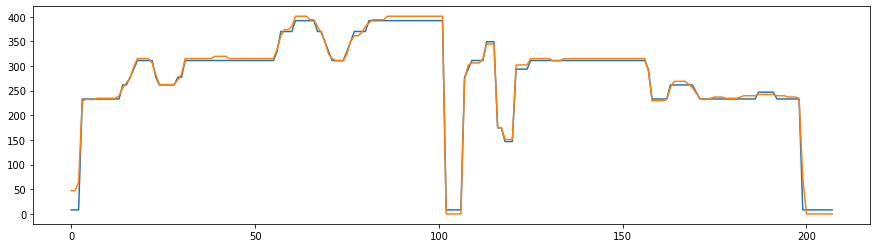

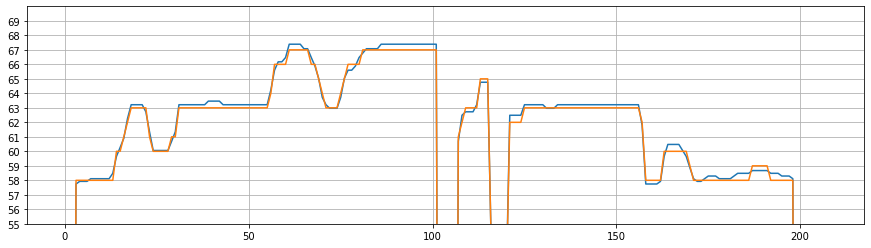

In [5]:
# replace zeros with 1 to avoid issues with log2 
pt4 = np.where(pt1==0, 1, pt1)
# convert to midi 
float_midi = 69 + 12*np.log2(pt4/440.)
# quantize midi 
int_midi = np.array([round(x) for x in float_midi])


for (i,f) in enumerate(float_midi): 
    if f < 40: 
        float_midi[i] = 0 
        int_midi[i] = 0 

print(float_midi[:20])
print(int_midi[:20])

# convert back to Hz
qpt = [440 * (2.0 ** ((x-69.0)/12.0)) for x in int_midi]

plt.figure(figsize=(15,4))
plt.plot(qpt)
plt.plot(pt1)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(float_midi)
plt.plot(int_midi)
plt.ylim(55, 70)
plt.grid(True)
plt.yticks(np.arange(55,70))
plt.show()



Ther idea behind autotuning is to detect the pitches of the sung melody 
and to shfit them to the closest pitch in some collection of pitches. Typical 
variants are the pitch to be sung if the melody is known, the closest pitch 
in a chromatic scale or the closest pitch in some user-provided scale. 

We can create a toy autotuning system using the sinusoid sonification 
which is easier to manipulate than arbitary audio. Let's listen 
to the sonified original pitch track, followed by the pitch track that 
is quantized to integer MIDI note numbers. The quantiztion to integer 
MIDI note numners can be viewed as a form of mapping pitches to target pitches. 
For this recording it is hard to listen to the difference but you can 
see/hear it near the end where there is some vibrato that 
disappears in the quantized recording. 

In [6]:
pt2_audio = sonify(at, qpt, srate, hopSize)
ipd.display(ipd.Audio(pt1_audio *2.0,rate=srate))
ipd.display(ipd.Audio(pt2_audio *2.0,rate=srate))


In many auto-tune applications the underlying melody is known in which case the target pitch is known 
rather than being the closest pitch in the chromatic scale. This is the case in Karaoke applications 
in which both the melody and the accompaniment is known. Another possibility is to use a diatonic scale 
instead of chromatic if we know something about the key or chord of the recording. For fun let's change one of the pitches of the extracted melody - changing it from a major scale to a minor scale. 

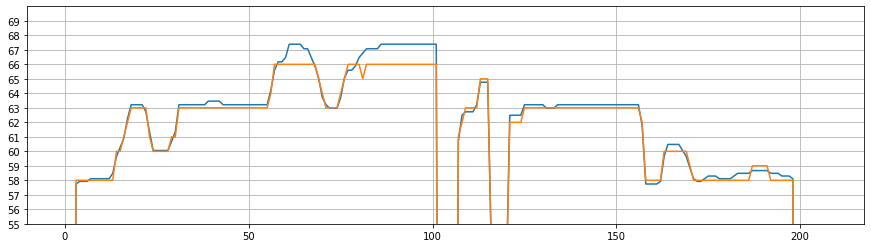

In [7]:
tuned = int_midi
for (k,p) in enumerate(qpt): 
    if (int_midi[k] == 67.0):
        tuned[k] = float_midi[k] -1.0 

minor_pt = [440 * (2.0 ** ((x-69.0)/12.0)) for x in tuned]
minor_audio = sonify(at, minor_pt, srate, hopSize)
ipd.display(ipd.Audio(minor_audio, rate=srate))

plt.figure(figsize=(15,4))
plt.plot(float_midi)
plt.plot(tuned)
plt.ylim(55, 70)
plt.grid(True)
plt.yticks(np.arange(55,70))
plt.show()


After seeing how we can "autotune" a sinusoidal oscillator now we need to be able to do the same with an audio recording. This is not a trivial process. We can raise the pitch by playing the audio faster or slower but that modifies the timing. Let's hear an example. We use resampling to achieve the faster/slower playback. We will raise/lower the pitch by 4 semitones. Notice the different durations. What we would like is to achieve the same pitch shifting but with retaining the same duration in the audio recording. 

In [8]:
ipd.display(ipd.Audio(audio_signal, rate=srate))

bins_per_octave = 12 
n_steps = 3 
pitch_shift_rate = 2.0 ** (-float(n_steps)/ bins_per_octave)
shifted = signal.resample(audio_signal, int(len(audio_signal) * pitch_shift_rate), axis=-1)
ipd.display(ipd.Audio(shifted, rate=srate))

n_steps = -4 
pitch_shift_rate = 2.0 ** (-float(n_steps)/ bins_per_octave)
shifted = signal.resample(audio_signal, int(len(audio_signal) * pitch_shift_rate), axis=-1)
ipd.display(ipd.Audio(shifted, rate=srate))


There are several techniques that can be used to achieve pitch shifting without time stretching or time stretching without pitvch shifting. To illustrate the problem consider a sinusoidal signal that contains several periods. When time stretching this sinusoid signal with interpolation the same number of periods will take longer which results in the lowering of the pitch. To time stretch without altering the pitch we need to somehow repeat more periods of the sinusoid. The basic idea is to keep track to phase and repeat periods as needed to time stretch. One approach is to directly repeat the waveform. Another approach is to decompose the signal into sinusoids and then stretch them individual taking care of the phase. This technique is called a phasevocoder and I am not going to go into details 
about how it operates. For illustration purposes I am going to use the Python bindings to a phasevocoder implementation called Rubberband. Notice that now the durations of the signal are the same. For fun we can create a simple harmonizer that adds a second voice to the original. The harmonizer can be made more sophisticated by for example taking into account knowledge of the underlying key/chord and extracted pitch. 

In [14]:
pip install pyrubberband


     |████████████████████████████████| 573 kB 2.1 MB/s eta 0:00:01
  Created wheel for pyrubberband: filename=pyrubberband-0.3.0-py3-none-any.whl size=4284 sha256=44e9d87911a0e491f70888e62b5828884463e5701e29c79930eb756545ef86a9
  Stored in directory: /Users/suyashramteke/Library/Caches/pip/wheels/28/34/95/3a3f9d5e29a45a2643273220746c27328ddfc052d6d52a5645
Successfully built pyrubberband
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install pyrubberband

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pyrubberband as pyrb

shifted_down = pyrb.pitch_shift(audio_signal, srate, -4)
shifted_up = pyrb.pitch_shift(audio_signal, srate, 3) 

ipd.display(ipd.Audio(audio_signal, rate=srate))
ipd.display(ipd.Audio(shifted_down, rate=srate))
ipd.display(ipd.Audio(shifted_up, rate=srate))

mix = (audio_signal + shifted_down + shifted_up) * 0.33
ipd.display(ipd.Audio(mix, rate=srate))


RuntimeError: Failed to execute rubberband. Please verify that rubberband-cli is installed.

We can also do more local modifications based on the underlying extracted pitch contour. For example lets hear how 
we can change the scale from major to minor as we did with the sinusoidal sonification using the actual audio recording. As you can hear there are some artifacts - these are too a large extent caused by this simple implementation but even with a better implementation any time/pitch modification introduces some artifacts. 
In some cases like T-pain style autotuning the artifacts become part of the aesthetic. 

In [14]:
import pyrubberband as pyrb

hopSize = 1024
winSize = 4096

offsets = np.arange(0, len(audio_signal)-winSize, hopSize)
output = np.zeros(len(audio_signal))

for (m,o) in enumerate(offsets): 
    
    steps = int_midi[m] - float_midi[m]
    if (int_midi[m] == 67.0):
        steps -= 1
    frame = audio_signal[o:o+winSize] 
    window = signal.hann(len(frame))
    frame = pyrb.pitch_shift(frame, srate, steps)
    frame = window * frame
    output[o:o+winSize] += frame


ipd.display(ipd.Audio(audio_signal,rate=22050))
ipd.display(ipd.Audio(output, rate=22050))


RuntimeError: Failed to execute rubberband. Please verify that rubberband-cli is installed.